In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import dotenv_values
from matplotlib.colors import LogNorm
from census import Census

In [2]:
config = dotenv_values(".env")

In [3]:
c = Census(config["CENSUS_API_KEY"])

In [4]:
blocks = gpd.read_file("../data/joins/block_dissolve.shp.zip")
blocks["GEOID_grp"] = blocks["GEOID20"].apply(lambda s: s[:-3])
blocks["GEOID_tract"]= blocks["GEOID20"].apply(lambda s: s[:-4])

In [5]:
blocks.head(1)

,GEOID20,UR20,UACE20,UATYPE20,ALAND20,AWATER20,HOUSING20,POP20,osmid_x,tract_osmi,...,AC_5,AC_10,AC_15,AC_20,AC_30,AC_45,AC_60,geometry,GEOID_grp,GEOID_tract
0,230010101001000,0.0,0.0,0.0,0,2552256,0,0,279296606904,2.792966e+11,...,0.0,8.703722,0.590484,2.192966,38.697977,185.288699,464.402438,"POLYGON ((-7817233.901 5480972.426, -7817213.6...",230010101001,23001010100


In [6]:
blocks.columns

Index(['GEOID20', 'UR20', 'UACE20', 'UATYPE20', 'ALAND20', 'AWATER20',
       'HOUSING20', 'POP20', 'osmid_x', 'tract_osmi', 'land_osmid',
       'trip_time', 'OBJECTID', 'RPT_AC', 'CALC_AC', 'IUCN_STATU',
       'CL_UNIQUEI', 'osmid_y', 'AC_5', 'AC_10', 'AC_15', 'AC_20', 'AC_30',
       'AC_45', 'AC_60', 'geometry', 'GEOID_grp', 'GEOID_tract'],
      dtype='object')

In [7]:
me_census = pd.DataFrame.from_records(c.pl.state_county_blockgroup(fields=('GEO_ID', 'P1_001N'),
                                      state_fips = "23",
                                      county_fips = "*",
                                      blockgroup="*",
                                      year = 2020))
me_census["GEOID_grp"] = me_census["GEO_ID"].apply(lambda s: s[9:])

In [8]:
merge = blocks.merge(me_census, how="left", on="GEOID_grp")


Text(0.5, 1.0, 'Population')

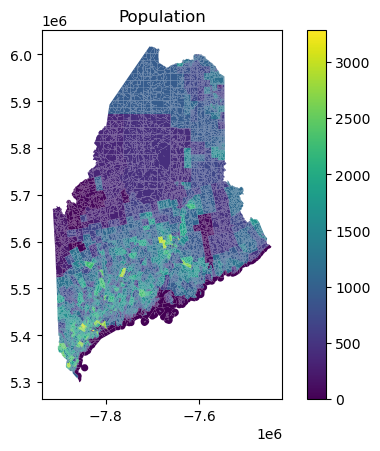

In [9]:
ax = merge.plot("P1_001N", linewidth=0, legend=True)
ax.set_title("Population")

In [32]:
desc = merge[merge["AC_60"]>0]["AC_60"].describe()
desc

count     26746.000000
mean       2252.500206
std       20553.028366
min           0.032276
25%          70.991690
50%         209.078972
75%         477.520463
max      712708.505658
Name: AC_60, dtype: float64

Text(0.5, 1.0, 'Acres of Conserved Land within 60 Minute Walk')

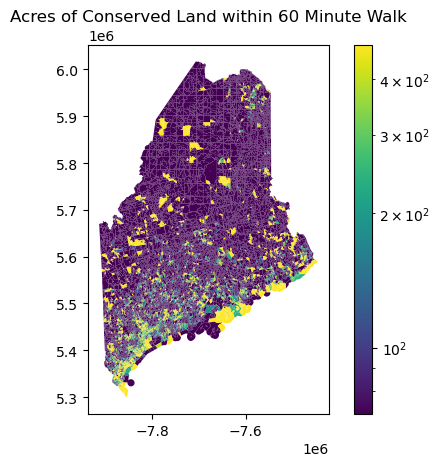

In [33]:
ax = merge.plot("AC_60", linewidth=0, legend=True, norm=LogNorm(desc["25%"], desc["75%"], clip=True))
ax.set_title("Acres of Conserved Land within 60 Minute Walk")

<AxesSubplot: xlabel='P1_001N', ylabel='CALC_AC'>

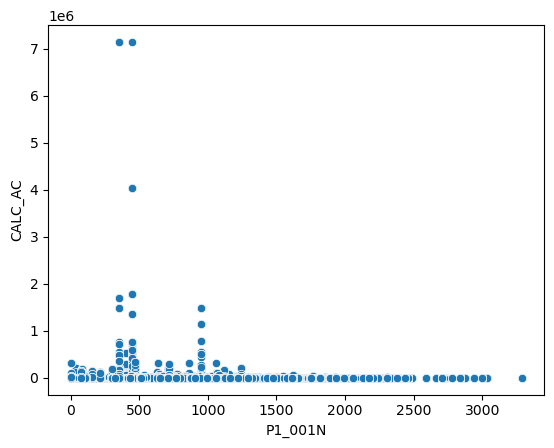

In [ ]:
sns.scatterplot(merge, x="P1_001N", y="CALC_AC")

In [ ]:
cejst = gpd.read_file("../data/cejst-me.zip", converters={"GEOID10": str})
cejst.head(1)

,GEOID10,SF,CF,DF_PFS,AF_PFS,HDF_PFS,DSF_PFS,EBF_PFS,EALR_PFS,EBLR_PFS,...,AGE_10,AGE_MIDDLE,AGE_OLD,TA_COU_116,TA_COUNT_C,TA_PERC,TA_PERC_FE,UI_EXP,THRHLD,geometry
0,23005002400,Maine,Cumberland County,0.25,0.57,0.62,0.2,0.8,0.16,0.47,...,0.04,0.61,0.34,NaN,NaN,NaN,NaN,Nation,21,"POLYGON ((-70.08518 43.70208, -70.08430 43.700..."


In [ ]:
relationships = pd.read_csv("../data/tab20_tract20_tract10_st23.txt", delimiter="|", dtype=str)
relationships.head(1)

,OID_TRACT_20,GEOID_TRACT_20,NAMELSAD_TRACT_20,AREALAND_TRACT_20,AREAWATER_TRACT_20,MTFCC_TRACT_20,FUNCSTAT_TRACT_20,OID_TRACT_10,GEOID_TRACT_10,NAMELSAD_TRACT_10,AREALAND_TRACT_10,AREAWATER_TRACT_10,MTFCC_TRACT_10,FUNCSTAT_TRACT_10,AREALAND_PART,AREAWATER_PART
0,20790167372390,23001010100,Census Tract 101,814411,147593,G5020,S,20740167372390,23001010100,Census Tract 101,880810,168949,G5020,S,789483,143413


In [ ]:
print("Before:", cejst.shape)
cejst20 = cejst.merge(relationships, how="right", left_on="GEOID10", right_on="GEOID_TRACT_20")
print("After:", cejst20.shape)

Before: (358, 124)
After: (491, 140)


In [ ]:
print("Before:", merge.shape)
ejblocks = gpd.GeoDataFrame(merge.merge(cejst20.groupby("GEOID_TRACT_20").first(), left_on="GEOID_tract", right_on="GEOID_TRACT_20"), geometry="geometry_x").drop(columns="geometry_y")
print("After:", ejblocks.shape)

Before: (47138, 34)
After: (47138, 172)


<AxesSubplot: xlabel='TC', ylabel='CALC_AC'>

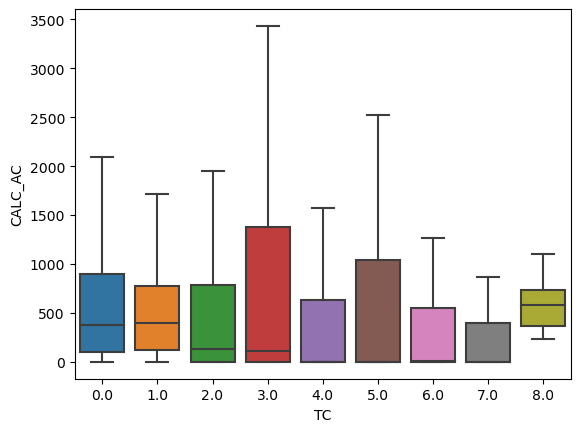

In [ ]:
sns.boxplot(ejblocks, x="TC", y="CALC_AC", showfliers=False)

In [18]:
ejblocks.to_file("../data/joins/ejblocks.shp.zip")

/tmp/ipykernel_12844/639181491.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ejblocks.to_file("../data/joins/ejblocks.shp.zip")


array([[<AxesSubplot: title={'center': 'TC'}>]], dtype=object)

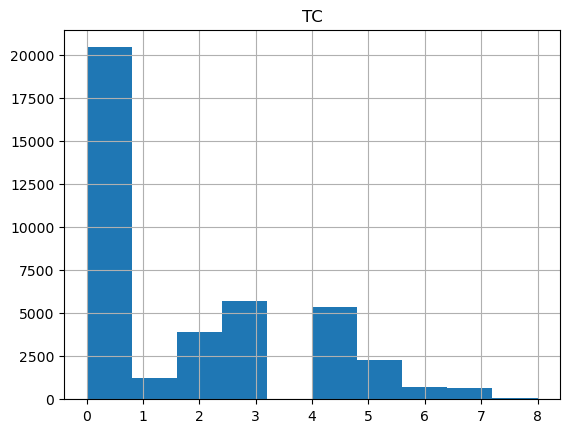

In [19]:
ejblocks.hist("TC")

Zero Inflated Poisson distribution

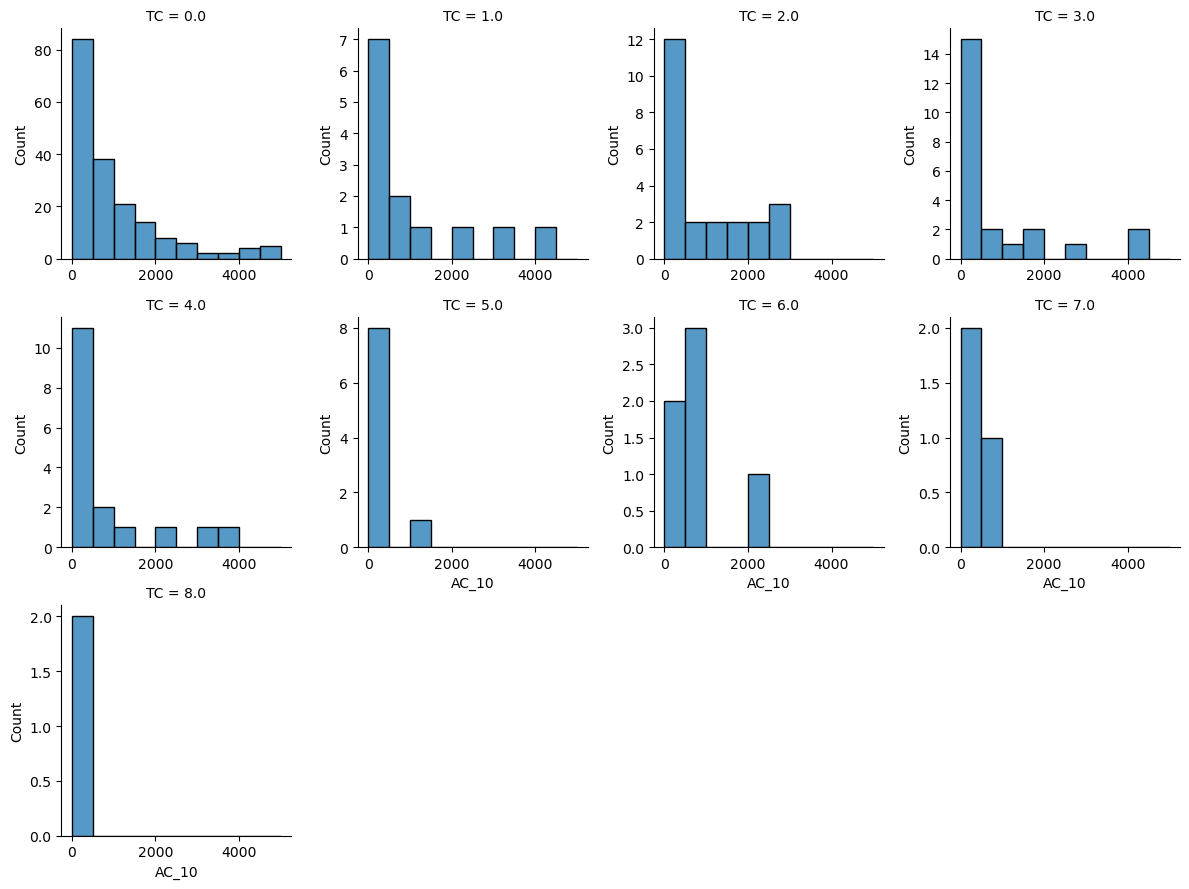

In [29]:
g = sns.FacetGrid(ejblocks.groupby("GEOID_tract").agg({"TC":"max", "AC_10":"sum"}), col="TC", col_wrap=4, sharex=False, sharey=False)
g.map(sns.histplot, "AC_10", bins=10, binrange=[0,5e3])